In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import bokeh.palettes as palette # For palette of colors

import time
import os
import glob
from joblib import Parallel, delayed
import dask.dataframe as dd
import dask.array as da 

from class_read_parallel import read_parallel

In [2]:
#!/usr/bin/env python
# coding: utf-8

# # SECOND ASSIGNMENT
#
# **GROUP: EARTHQUAKES**
#
# Guadagnini Michele - 1230663
#
# Lambertini Alessandro - 1242885
#
# Pagano Alice - 1236916
#
# Puppin Michele - 1227474

# Import main packages 
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.palettes as palette # For palette of colors

import time
import os
import glob
from joblib import Parallel, delayed
import dask.dataframe as dd



class read_parallel:


        # Read a single chunk of data with dask and joblib
        def read_chunks(self,i, j, m):
                cols = pd.read_csv('/data1/collaborator/modB/simulations_fMT01/A5/0.002/chunk0/evol_mergers.out',sep="\s+",nrows=1,header=None).iloc[0].values[1:]
                path = '/data1/collaborator/modB/simulations_fMT'+i+'/A5/'+j+'/chunk'+m+'/evol_mergers.out'
                columns_to_read = [cols[0],cols[1],cols[2],cols[4],cols[16],cols[18],cols[31],cols[33]]   
                dataframe = pd.read_csv(path,sep="\s+",skiprows=1,header=None,usecols=columns_to_read,names=cols)
                return dataframe



        # Filter a single chunk of data for black holes
        def filter_chunks_BH(self,data):           
                data_BH = data[ data['k1[2]']==14 ]
                data_BH = data_BH[ data_BH['k2[16]']==14 ]
                index_BH = list(data_BH['ID[0]'].unique()) 
                data_BH = data[ data['ID[0]'].isin(index_BH) ]       
                return data_BH



        # Filter a single chunk of data for common envelope
        def filter_chunks_CE(self,data):      
                data_CE = data[ data['label[33]']=='COMENV' ]
                index_CE = list(data_CE['ID[0]'].unique()) 
                data_CE = data[ data['ID[0]'].isin(index_CE) ]     
                return data_CE



        # Filter a single chunk of data for no common envelope
        def filter_chunks_nCE(self,data):
                data_CE = data[ data['label[33]']=='COMENV' ]
                index_CE = list(data_CE['ID[0]'].unique()) 
                data_nCE = data[ ~data['ID[0]'].isin(index_CE) ]
                return data_nCE
        


        # Filter a single chunk of data for a initial mass
        def filter_chunks_initial(self,data):
                data = data[ data['label[33]']=='INITIAL' ]
                return data
        


        # Filter a single chunk of data for final mass
        def filter_chunks_final(self, data):
                data = data[ data['k1[2]']==14 ]
                data = data[ data['k2[16]']==14 ]
                data = data.groupby('ID[0]').first().reset_index(drop=False)           
                return data



        # Filter a single chunk of data for delay times
        def filter_chunks_dtimes(self, data):
                data = data[ data['label[33]']=='COELESCE' ]
                return data
            
            

        # Organize data by reordering them
        def organize_data(self,data_CE,data_nCE,fMT,metal,chunk):
                df_fMT_CE = []
                df_fMT_nCE = []
                for i in fMT:
                        df_metal_CE = []
                        df_metal_nCE = []
                        for j in metal:
                                df_chunk_CE = []
                                df_chunk_nCE = []
                                for m in chunk:
                                        # Read chunk with/without CE
                                        df_CE = data_CE[fMT.index(i)*len(metal)*len(chunk)+metal.index(j)*len(chunk)+chunk.index(m)]
                                        df_nCE = data_nCE[fMT.index(i)*len(metal)*len(chunk)+metal.index(j)*len(chunk)+chunk.index(m)]

                                        df_chunk_CE.append(df_CE)
                                        df_chunk_nCE.append(df_nCE)

                                df_metal_CE.append(pd.concat(df_chunk_CE,ignore_index=True)) 
                                df_metal_nCE.append(pd.concat(df_chunk_nCE,ignore_index=True))
                        
                         # Merging metallicities until 0.002
                        df_metal_u_CE = pd.concat(df_metal_CE[:5],ignore_index=True)
                        df_metal_CE.append(df_metal_u_CE)
                        df_metal_u_nCE = pd.concat(df_metal_nCE[:5],ignore_index=True)
                        df_metal_nCE.append(df_metal_u_nCE)
                        
                        df_fMT_CE.append(df_metal_CE)
                        df_fMT_nCE.append(df_metal_nCE)

                return df_fMT_CE, df_fMT_nCE

In [3]:
read_parallel = read_parallel()

fMT = ['01','02','03','04','05','07','1']
metal = ['0.0002','0.0004','0.0008','0.0012','0.0016','0.002','0.004','0.006','0.008','0.012','0.016','0.02']
chunk = ['0','1','2','3','4']

start_time = time.time()

# Read all chunks in parallel
single_chunk = Parallel(n_jobs=32)(delayed(read_parallel.read_chunks)(i, j, m) for i in fMT for j in metal for m in chunk)

end_time = time.time()
print("Times in seconds: "+str(end_time-start_time))

Times in seconds: 72.19453763961792


In [4]:
start_time = time.time()
data_BH = [read_parallel.filter_chunks_BH(data) for data in single_chunk]
data_CE = [read_parallel.filter_chunks_CE(data) for data in data_BH]
data_nCE = [read_parallel.filter_chunks_nCE(data) for data in data_BH]

data_CE_initial = [read_parallel.filter_chunks_initial(data) for data in data_CE]
data_nCE_initial = [read_parallel.filter_chunks_initial(data) for data in data_nCE]

data_CE_final = [read_parallel.filter_chunks_final(data) for data in data_CE]
data_nCE_final = [read_parallel.filter_chunks_final(data) for data in data_nCE]

data_CE_dtimes = [read_parallel.filter_chunks_dtimes(data) for data in data_CE]
data_nCE_dtimes = [read_parallel.filter_chunks_dtimes(data) for data in data_nCE]

end_time = time.time()
print("Times in seconds: "+str(end_time-start_time))

Times in seconds: 59.2934889793396


In [5]:
data_CE_final[0].head()

,ID[0],t_step[1],k1[2],mt1[4],k2[16],mt2[18],sep[31],label[33]
0,564,9.1738,14,4.5595,14,3.5053,7.4969,KW_CHNGE
1,1142,7.9152,14,9.9049,14,5.7230,7.3942,KW_CHNGE
2,1333,6.6238,14,10.4825,14,7.2326,5.6807,KW_CHNGE
3,1650,8.8866,14,6.9983,14,3.6739,4.8051,KW_CHNGE
4,1769,9.0901,14,5.3701,14,4.5128,11.0540,KW_CHNGE


In [6]:
data_CE_filtered = []
data_nCE_filtered = []

for i in range(len(data_CE)):
    frame_CE = {'m1_init' : np.array(data_CE_initial[i]['mt1[4]']),
                'm2_init' : np.array(data_CE_initial[i]['mt2[18]']),
                'm1_fin' : np.array(data_CE_final[i]['mt1[4]']),
                'm2_fin' : np.array(data_CE_final[i]['mt2[18]']),
                'sep'    : np.array(data_CE_final[i]['sep[31]']),
                'dtimes' : np.array(data_CE_dtimes[i]['t_step[1]'])}
    dataframe_CE = pd.DataFrame(frame_CE) 
    
    frame_nCE = {'m1_init' : np.array(data_nCE_initial[i]['mt1[4]']),
                 'm2_init' : np.array(data_nCE_initial[i]['mt2[18]']),
                 'm1_fin' : np.array(data_nCE_final[i]['mt1[4]']),
                 'm2_fin' : np.array(data_nCE_final[i]['mt2[18]']),
                 'sep'    : np.array(data_nCE_final[i]['sep[31]']),
                 'dtimes' : np.array(data_nCE_dtimes[i]['t_step[1]'])}
    dataframe_nCE = pd.DataFrame(frame_nCE) 
    
    data_CE_filtered.append(dataframe_CE)
    data_nCE_filtered.append(dataframe_nCE)

In [7]:
start_time = time.time()
df_fMT_CE, df_fMT_nCE = read_parallel.organize_data(data_CE_filtered, data_nCE_filtered,fMT,metal,chunk)
end_time = time.time()
print("Times in seconds: "+str(end_time-start_time))

Times in seconds: 0.7325763702392578


In [8]:
class plot_hist:


        def mass(self,df_CE,df_nCE,fMT,m_str,title_str): #(dataframe,fMT,metal)
    
                fig = plt.figure(figsize=(10,12))
                ax = [fig.add_subplot(2,1,s) for s in range(1,3)] #nrows,ncols,index
                fig.suptitle('Distribution of mass '+title_str, fontsize=24)
                col = sns.color_palette(palette.viridis(len(fMT)))
                fMT_p = ['0.1','0.2','0.3','0.4','0.5','0.7','1.0']
                
                ax[0].get_shared_x_axes().join(ax[0], ax[1])

                met_id = 12     #index of grouped metallicities !!!!!!!! CAZZO!
                for i in range(0,2):                            
                    for j in range(0, len(fMT)):
                        
                        if i==0 :
                            string = fMT_p[j]+'  ({})'.format(df_CE[j][met_id][m_str].shape[0])
                            sns.distplot(df_CE[j][met_id][m_str],kde=False,norm_hist=True,label=string, 
                            hist_kws={"histtype": "step","lw": 2},ax=ax[i],color=col[j])
                        else:
                            string = fMT_p[j]+'  ({})'.format(df_nCE[j][met_id][m_str].shape[0])
                            sns.distplot(df_nCE[j][met_id][m_str],kde=False,norm_hist=True,label=string, 
                            hist_kws={"histtype": "step","lw": 2},ax=ax[i],color=col[j])
                    
                    #ax[i].set_title('Distribution of mass '+m_str+' for fMT={}'.format(fMT[i]),fontsize=16)
                    ax[0].set_xlabel('',fontsize=16)
                    ax[1].set_xlabel('m $[M_\odot]$',fontsize=16)
                    ax[i].set_ylabel('Density',fontsize=16)
                    #ax[i].set_xscale('log')
                    ax[i].legend(title='fMT',fontsize=14,title_fontsize=16,loc='upper right')
                    ax[i].tick_params(axis="x", labelsize=16)
                    ax[i].tick_params(axis="y", labelsize=16)
                    ax[i].grid(True, which="both", ls="-",color='0.93')
                    ax[i].set_axisbelow(True)
                    ax[0].annotate('Common Envelope', xy=(0.6, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                    ax[1].annotate('no Common Envelope', xy=(0.6, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                    
                fig.tight_layout(rect=[0, 0., 1, 0.95])
                    
                if not os.path.isdir('./hist_fMT'):
                    os.mkdir('./hist_fMT')
                plt.savefig('hist_fMT/hist_'+m_str+'_fMT.pdf', format='pdf')
                #plt.close()
        
        def dtimes(self,df_CE,df_nCE,fMT): #(dataframe,fMT,metal)

                fig = plt.figure(figsize=(10,12))
                ax = [fig.add_subplot(2,1,s) for s in range(1,3)] #nrows,ncols,index
                fig.suptitle('Distribution of merging times',fontsize=24)   
                col = sns.color_palette(palette.viridis(len(fMT)))
                fMT_p = ['0.1','0.2','0.3','0.4','0.5','0.7','1.0']
                
                ax[0].get_shared_x_axes().join(ax[0], ax[1])
                
                met_id = 12

                for i in range(0,len(fMT)):              
                    string = fMT_p[i]+'  ({})'.format(df_CE[i][met_id]['dtimes'].shape[0])
                    sns.distplot(df_CE[i][met_id]['dtimes'],kde=False,norm_hist=True,label=string, 
                                            hist_kws={"histtype": "step","lw": 2},ax=ax[0],color=col[i])
                    
                    string = fMT_p[i]+'  ({})'.format(df_nCE[i][met_id]['dtimes'].shape[0])
                    sns.distplot(df_nCE[i][met_id]['dtimes'],kde=False,norm_hist=True,label=string, 
                                            hist_kws={"histtype": "step","lw": 2},ax=ax[1],color=col[i])
                for i in range(0,2):
                    #ax[i].set_title('Distribution of delay times for fMT={}'.format(fMT[i]),fontsize=18)
                    ax[0].set_xlabel('',fontsize=16)
                    ax[1].set_xlabel('t $[Myr]$',fontsize=16)
                    ax[i].set_ylabel('Density',fontsize=16)
                    #ax[i].set_xscale('log')
                    #ax[i].set_yscale('log')
                    ax[i].legend(title='fMT',fontsize=14,title_fontsize=16,loc='upper right')
                    ax[i].tick_params(axis="x", labelsize=16)
                    ax[i].tick_params(axis="y", labelsize=16)
                    ax[i].grid(True, which="both", ls="-",color='0.93')
                    ax[i].set_axisbelow(True)
                    
                ax[0].annotate('Common Envelope', xy=(0.6, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                ax[1].annotate('no Common Envelope', xy=(0.6, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                    
                fig.tight_layout(rect=[0, 0., 1, 0.95])
        
                if not os.path.isdir('./hist_fMT'):
                       os.mkdir('./hist_fMT')

                plt.savefig('hist_fMT/hist_dtimes_fMT.pdf', format='pdf')
                #plt.close()
        
        
        def mass_ratio(self,df_CE, fMT, CEstr): #(dataframe,fMT,metal)
    
                fig = plt.figure(figsize=(10,18))
                ax = [fig.add_subplot(3,1,s) for s in range(1,4)] #nrows,ncols,index
                fig.suptitle('Distribution of mass ratio for '+CEstr, fontsize=24)        
                col = palette.viridis(len(fMT))
                #fig.subplots_adjust(top=0.95)
                fMT_p = ['0.1','0.2','0.3','0.4','0.5','0.7','1.0']
                
                ax[0].get_shared_x_axes().join(ax[0], ax[1], ax[2])
                
                met_id = 12
                
                for j in range(0,3):
                    for i in range(0,len(fMT)):
                            
                        q_initial_CE = df_CE[i][met_id]['m2_init']/df_CE[i][met_id]['m1_init']
                        q_final_CE = df_CE[i][met_id]['m2_fin']/df_CE[i][met_id]['m1_fin']
                        
                        mask = df_CE[i][met_id]['m2_fin']>df_CE[i][met_id]['m1_fin']
                        #df_CE['flip_mask'] = mask
                        df_CE[i][met_id]['m1_fin_flip'] = np.where(mask, df_CE[i][met_id]['m2_fin'], df_CE[i][met_id]['m1_fin'])
                        df_CE[i][met_id]['m2_fin_flip'] = np.where(mask, df_CE[i][met_id]['m1_fin'], df_CE[i][met_id]['m2_fin'])
                        
                        q_final_flip = df_CE[i][met_id]['m2_fin_flip']/df_CE[i][met_id]['m1_fin_flip']
                        
                        if j==0:
                            string = fMT_p[i]+'  ({})'.format(df_CE[i][met_id]['m1_init'].shape[0])
                            sns.distplot(q_initial_CE,kde=False,norm_hist=True,label=string, 
                                    hist_kws={"histtype": "step","lw": 2},ax=ax[0],color=col[i])
                        if j==1:
                            string = fMT_p[i]+'  ({})'.format(df_CE[i][met_id]['m1_fin'].shape[0])
                            sns.distplot(q_final_CE,kde=False,norm_hist=True,label=string, 
                                    hist_kws={"histtype": "step","lw": 2},ax=ax[1],color=col[i])
                        if j==2:
                            string = fMT_p[i]+'  ({})'.format(df_CE[i][met_id]['m1_fin'].shape[0])
                            sns.distplot(q_final_flip,kde=False,norm_hist=True,label=string, 
                                    hist_kws={"histtype": "step","lw": 2},ax=ax[2],color=col[i])

                    #ax[j].set_title('Distribution of initial and final mass ratio CE for fMT={}'.format(fMT[i]),fontsize=18)
                    ax[0].set_xlabel('',fontsize=16)
                    ax[1].set_xlabel('',fontsize=16)
                    ax[2].set_xlabel('q',fontsize=16)
                    ax[j].set_ylabel('Density',fontsize=16)
                    #ax[j].set_yscale('log')
                    ax[j].legend(title='fMT',fontsize=14,title_fontsize=16,loc='best')
                    ax[j].tick_params(axis="x", labelsize=16)
                    ax[j].tick_params(axis="y", labelsize=16)
                    ax[j].grid(True, which="both", ls="-",color='0.93')
                    ax[j].set_axisbelow(True)
                    ax[0].annotate('Initial mass ratio', xy=(0.6, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                                       
                    if (CEstr=='nCE'):
                        ax[1].legend(title='fMT',fontsize=14,title_fontsize=16,loc='upper left')
                        ax[1].annotate('Final mass ratio', xy=(0.4, 0.93), xycoords='axes fraction',
                              fontsize=16, ha='center')
                        ax[2].legend(title='fMT',fontsize=14,title_fontsize=16,loc='upper left')
                        ax[2].annotate('Ordered Final mass ratio', xy=(0.4, 0.93), xycoords='axes fraction',
                              fontsize=16, ha='center')
                    else:
                        ax[1].annotate('Final mass ratio', xy=(0.6, 0.93), xycoords='axes fraction',
                              fontsize=16, ha='center')
                        ax[2].annotate('Ordered Final mass ratio', xy=(0.55, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                
                fig.tight_layout(rect=[0, 0., 1, 0.95])
                                    
                if not os.path.isdir('./hist_fMT'):
                     os.mkdir('./hist_fMT')
                plt.savefig('hist_fMT/hist_q_fMT_'+CEstr+'.pdf', format='pdf')
                #plt.close()
                
                
                
        def scatter_mass(self,df_CE,df_nCE,fMT,m_str): #(dataframe,fMT,metal)
            
                fig = plt.figure(figsize=(10,12))
                ax = [fig.add_subplot(2,1,s) for s in range(1,3)] #nrows,ncols,index
                fig.suptitle('Scatter plot of '+m_str, fontsize=24)
                col = sns.color_palette(('#440154', '#22A784'))
                #col = palette.viridis(2)
                #fMT_p = ['0.1','0.2','0.3','0.4','0.5','0.7','1.0']
                ax[0].get_shared_x_axes().join(ax[0], ax[1])
                
                met_id = 12
                
                if m_str == 'Initial masses':
                    m1_str = 'm1_init'
                    m2_str = 'm2_init'
                if m_str == 'Final masses':
                    m1_str = 'm1_fin'
                    m2_str = 'm2_fin'
                if m_str == 'Ordered final masses':
                    m1_str = 'm1_fin_flip'
                    m2_str = 'm2_fin_flip'
                
                CE_counts  = 0
                nCE_counts = 0

                for j in range(0, len(fMT)):
                            
                        mask = df_CE[j][met_id]['m2_fin']>df_CE[j][met_id]['m1_fin']
                        df_CE[j][met_id]['m1_fin_flip'] = np.where(mask, df_CE[j][met_id]['m2_fin'], df_CE[j][met_id]['m1_fin'])
                        df_CE[j][met_id]['m2_fin_flip'] = np.where(mask, df_CE[j][met_id]['m1_fin'], df_CE[j][met_id]['m2_fin'])

                        mask = df_nCE[j][met_id]['m2_fin']>df_nCE[j][met_id]['m1_fin']
                        df_nCE[j][met_id]['m1_fin_flip'] = np.where(mask, df_nCE[j][met_id]['m2_fin'], df_nCE[j][met_id]['m1_fin'])
                        df_nCE[j][met_id]['m2_fin_flip'] = np.where(mask, df_nCE[j][met_id]['m1_fin'], df_nCE[j][met_id]['m2_fin'])

                        CE_counts  += df_CE[j][met_id][m1_str].shape[0]
                        nCE_counts += df_nCE[j][met_id][m1_str].shape[0]
                        
                df_CE_full = pd.concat([df_CE[p][met_id] for p in range(len(fMT))], ignore_index=True)       
                df_nCE_full = pd.concat([df_nCE[p][met_id] for p in range(len(fMT))], ignore_index=True)    
                        
                x = df_CE_full[m1_str]
                y = df_CE_full[m2_str]
                    
                xedges = np.linspace(x.min()-1, x.max()+1, 80)
                yedges = np.linspace(y.min()-1, y.max()+1, 80)
                hist, xedges, yedges = np.histogram2d(x, y, (xedges, yedges))
                xidx = np.clip(np.digitize(x, xedges)-1, 0, hist.shape[0]-1)
                yidx = np.clip(np.digitize(y, yedges)-1, 0, hist.shape[1]-1)
                c = hist[xidx, yidx]
                
                #ax[0].scatter(x, y, c=col[1], alpha=0.5, s=0.5)  
            
                h1 = ax[0].scatter(x, y, c=c, s=2, alpha=0.4, norm=mpl.colors.LogNorm())            
                
                x = df_nCE_full[m1_str]
                y = df_nCE_full[m2_str]
                    
                xedges = np.linspace(x.min()-1, x.max()+1, 80)
                yedges = np.linspace(y.min()-1, y.max()+1, 80)
                hist, xedges, yedges = np.histogram2d(x, y, (xedges, yedges))
                xidx = np.clip(np.digitize(x, xedges)-1, 0, hist.shape[0]-1)
                yidx = np.clip(np.digitize(y, yedges)-1, 0, hist.shape[1]-1)
                c = hist[xidx, yidx]
                
                h2 = ax[1].scatter(x, y, c=c, s=2, alpha=0.4, norm=mpl.colors.LogNorm())
                
                #ax[1].scatter(x, y, c=col[1], alpha=0.5, s=0.5)   
                        
                plt.colorbar(h1, ax=ax[0], label='Counts')
                ax[0].set_xlabel('',fontsize=16)
                plt.colorbar(h2, ax=ax[1], label='Counts')
                ax[1].set_xlabel('m1 $[M_\odot]$',fontsize=16)
                
                for i in range(0,2):
                        ax[i].set_ylabel('m2 $[M_\odot]$',fontsize=16)
                        #ax[i].set_xscale('log')
                        #ax[i].legend(fontsize=14,title_fontsize=16,loc='upper right')
                        ax[i].tick_params(axis="x", labelsize=16)
                        ax[i].tick_params(axis="y", labelsize=16)
                        ax[i].grid(True, which="both", ls="-",color='0.93')
                        ax[i].set_axisbelow(True)
                ax[0].annotate('Common Envelope   ({})'.format(CE_counts), xy=(0.05, 0.93), xycoords='axes fraction',
                               fontsize=16)
                ax[1].annotate('no Common Envelope   ({})'.format(nCE_counts), xy=(0.05, 0.93), xycoords='axes fraction',
                               fontsize=16)

                fig.tight_layout(rect=[0, 0., 1, 0.95])
                
                if not os.path.isdir('./hist_fMT'):
                    os.mkdir('./hist_fMT')
                plt.savefig('hist_fMT/scatter'+m_str+'.png', format='png')
                plt.savefig('hist_fMT/scatter'+m_str+'.pdf', format='pdf')
                #plt.close()
                
        def sep(self,df_CE,df_nCE,fMT): #(dataframe,fMT,metal)
    
                fig = plt.figure(figsize=(10,12))
                ax = [fig.add_subplot(2,1,s) for s in range(1,3)] #nrows,ncols,index
                fig.suptitle('Distribution of semi-major axis', fontsize=24)
                col = sns.color_palette(palette.viridis(len(fMT)))
                fMT_p = ['0.1','0.2','0.3','0.4','0.5','0.7','1.0']
                
                ax[0].get_shared_x_axes().join(ax[0], ax[1])
                binnn = [15, 20, 30,30,30,30,30]
                
                met_id = 12
                
                for i in range(0,2):
                            
                    for j in range(0, len(fMT)):
                        
                        if i==0 :
                            edge = np.logspace(np.log10(df_CE[j][met_id]['sep'].min()), np.log10(df_CE[j][met_id]['sep'].max()), 30)
                            string = fMT_p[j]+'  ({})'.format(df_CE[j][met_id]['sep'].shape[0])
                            sns.distplot(df_CE[j][met_id]['sep'],bins=edge,kde=False,norm_hist=True,label=string, 
                            hist_kws={"histtype": "step","lw": 2},ax=ax[i],color=col[j])
                        else:
                            edge = np.logspace(np.log10(df_nCE[j][met_id]['sep'].min()), np.log10(df_nCE[j][met_id]['sep'].max()), binnn[j])
                            string = fMT_p[j]+'  ({})'.format(df_nCE[j][met_id]['sep'].shape[0])
                            sns.distplot(df_nCE[j][met_id]['sep'],bins=edge,kde=False,norm_hist=True,label=string, 
                            hist_kws={"histtype": "step","lw": 2},ax=ax[i],color=col[j])
                    
                    #ax[i].set_title('Distribution of mass '+m_str+' for fMT={}'.format(fMT[i]),fontsize=16)
                    ax[0].set_xlabel('',fontsize=16)
                    ax[1].set_xlabel('semi-major axis $[R_\odot]$',fontsize=16)
                    ax[i].set_ylabel('Density',fontsize=16)
                    ax[i].set_xscale('log')
                    ax[i].set_yscale('log')
                    ax[i].legend(title='fMT',fontsize=14,title_fontsize=16,loc='upper right')
                    ax[i].tick_params(axis="x", labelsize=16)
                    ax[i].tick_params(axis="y", labelsize=16)
                    ax[i].grid(True, which="both", ls="-",color='0.93')
                    ax[i].set_axisbelow(True)
                    ax[0].annotate('Common Envelope', xy=(0.6, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                    ax[1].annotate('no Common Envelope', xy=(0.6, 0.93), xycoords='axes fraction',
                           fontsize=16, ha='center')
                    
                fig.tight_layout(rect=[0, 0., 1, 0.95])
                    
                if not os.path.isdir('./hist_fMT'):
                    os.mkdir('./hist_fMT')
                plt.savefig('hist_fMT/hist_sep_fMT.pdf', format='pdf')
                #plt.close()        


In [9]:
plot_hist = plot_hist()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Times in seconds: 1027.7862553596497


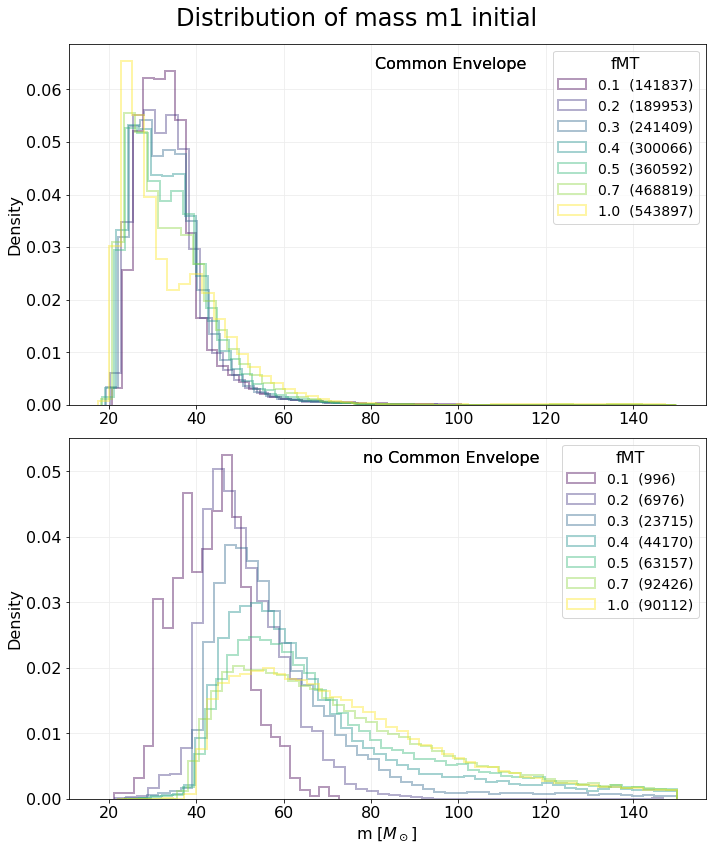

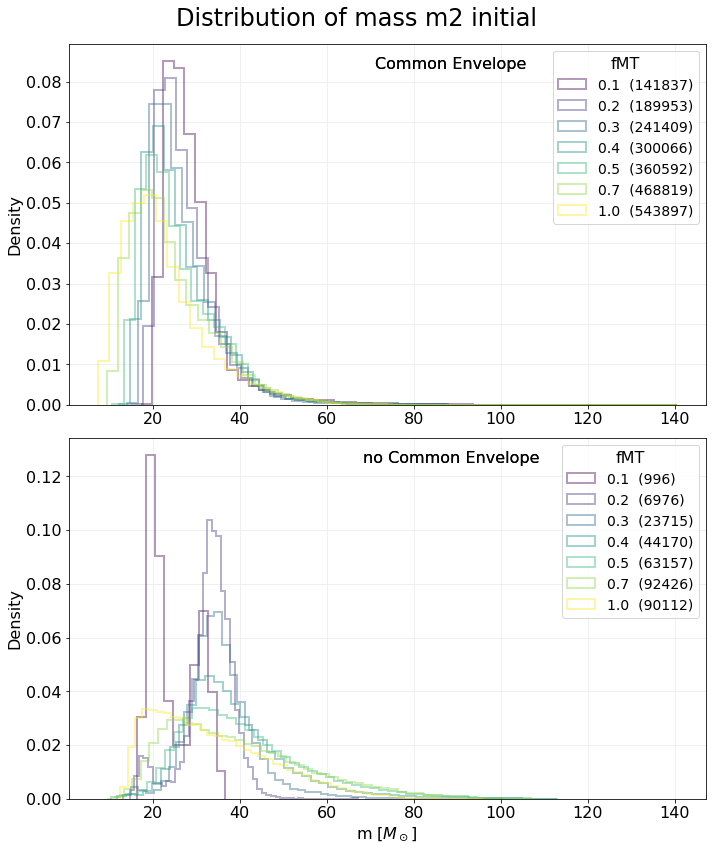

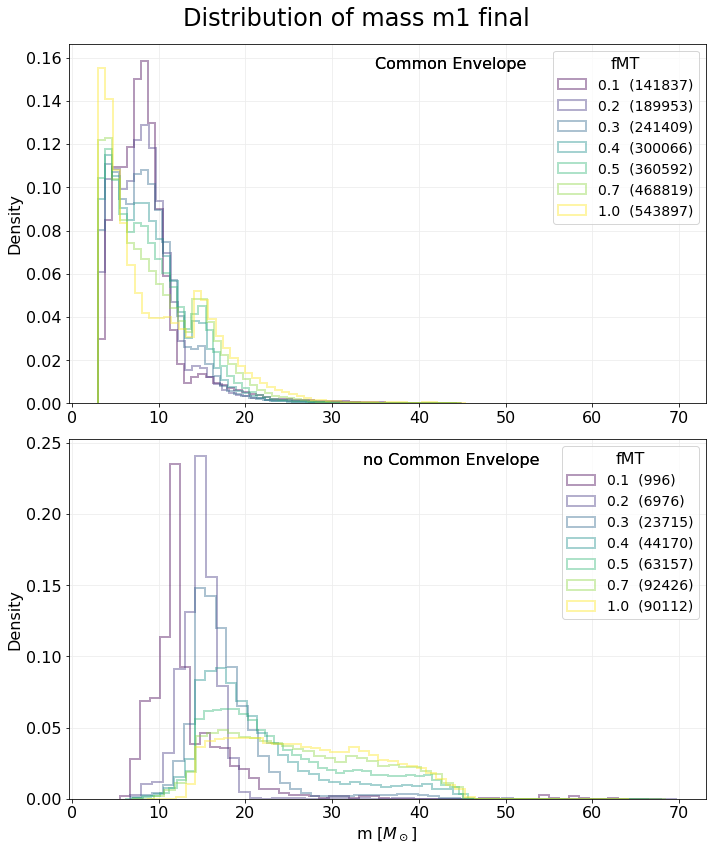

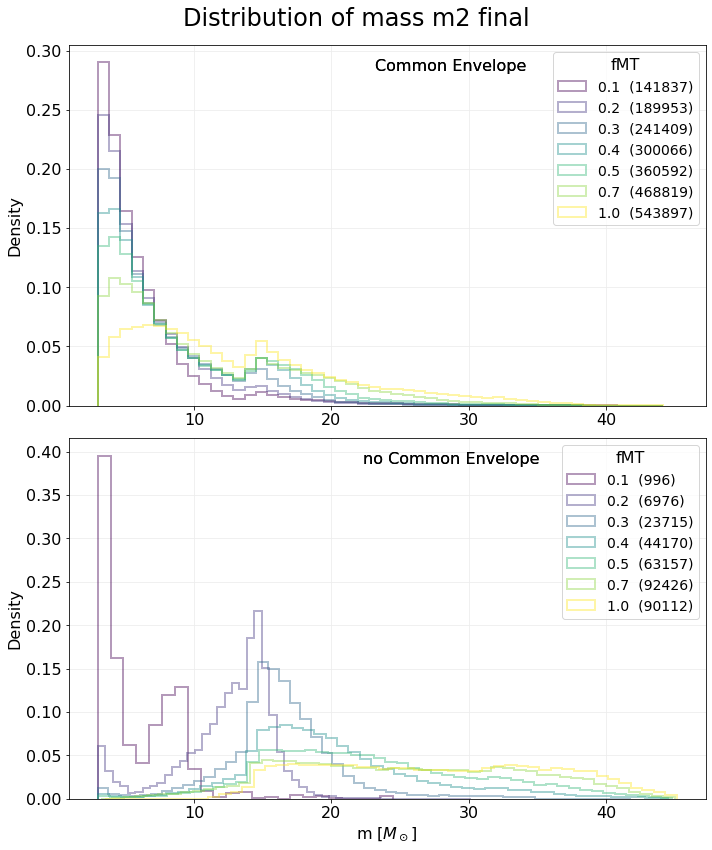

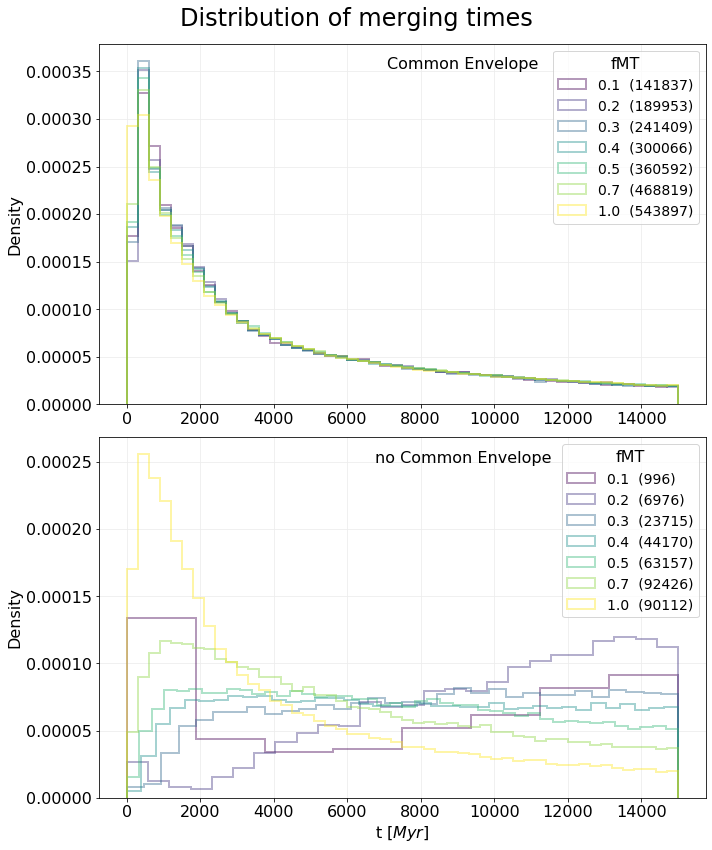

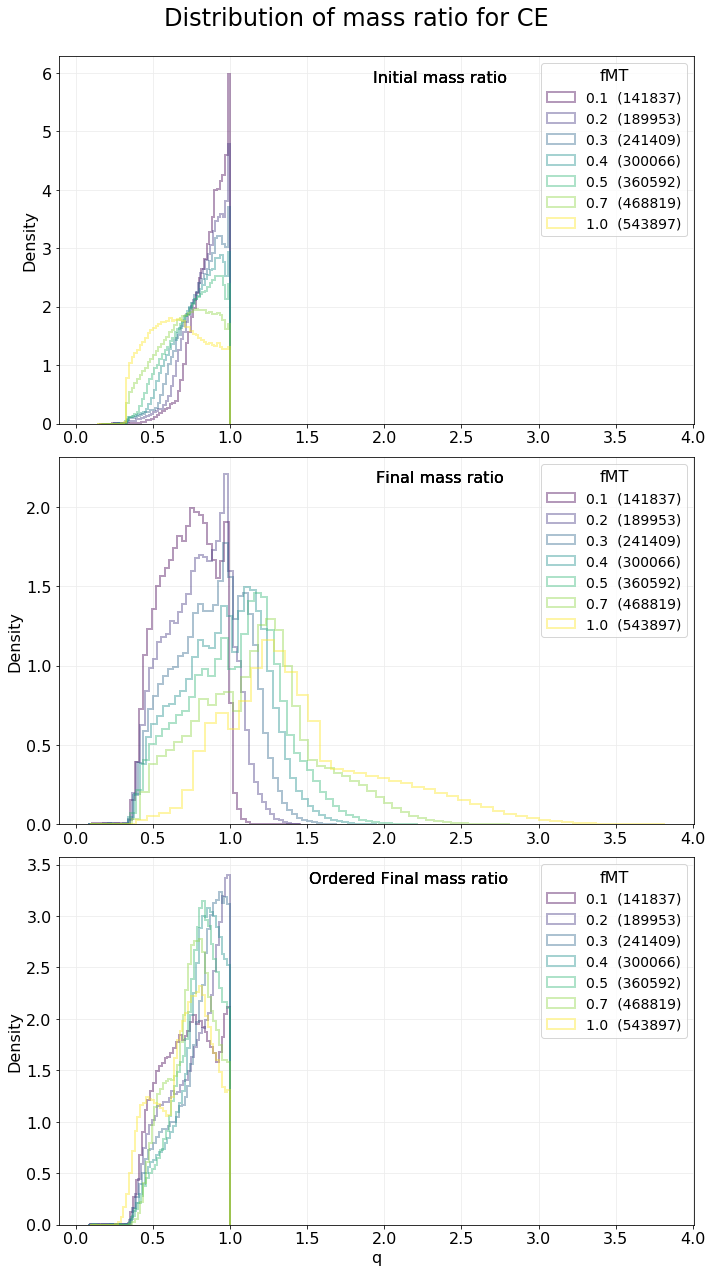

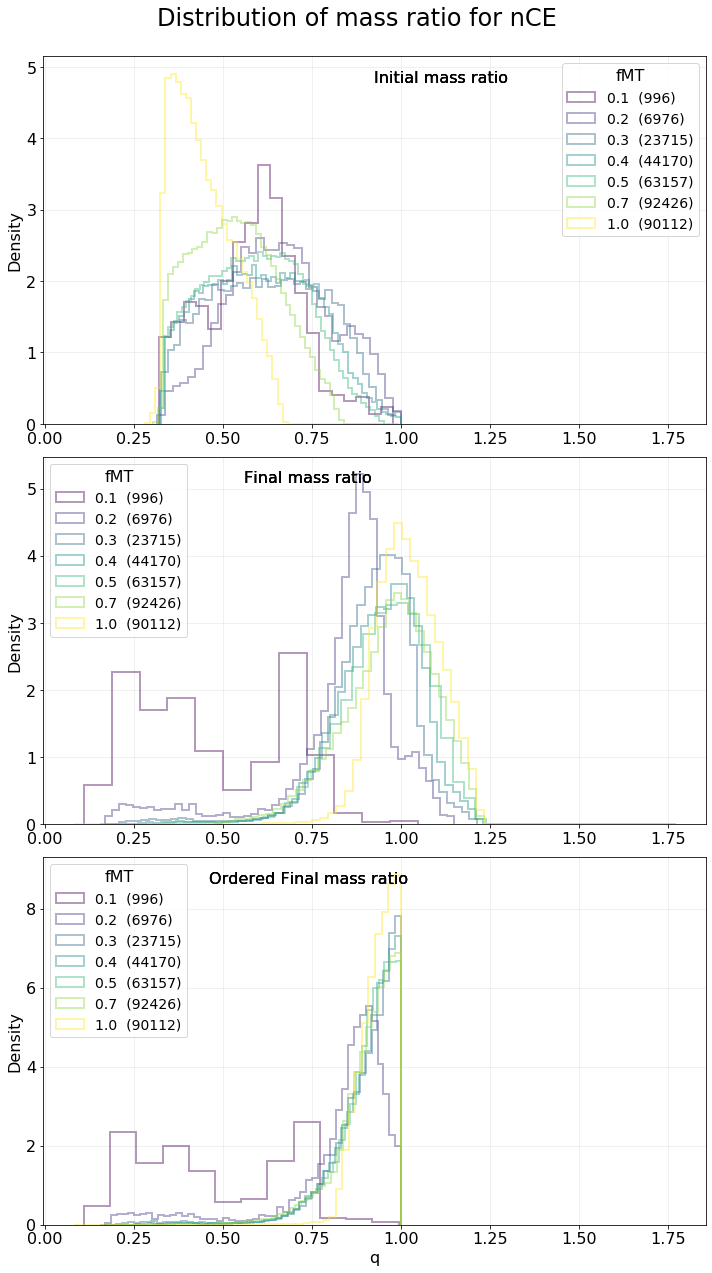

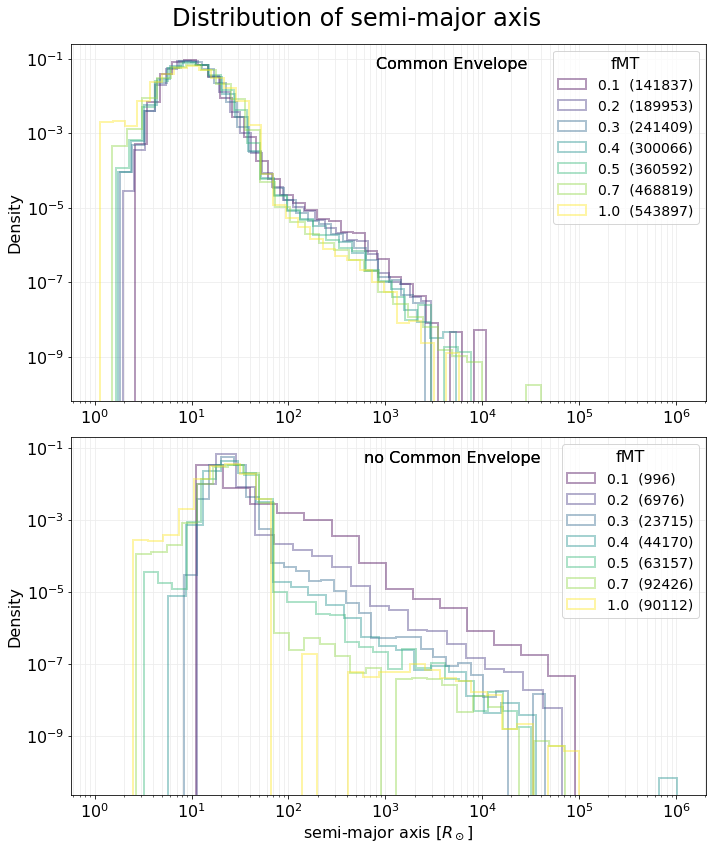

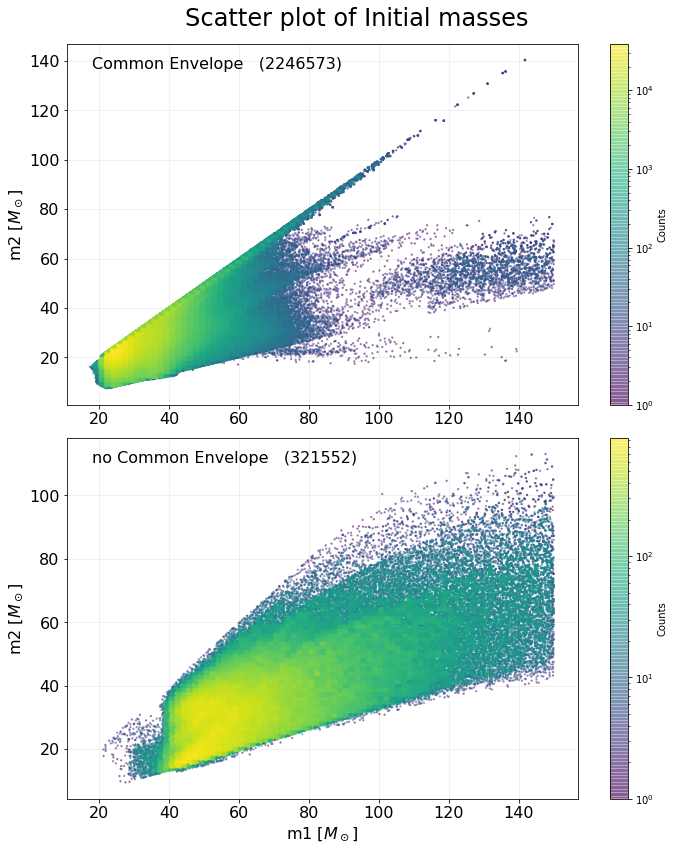

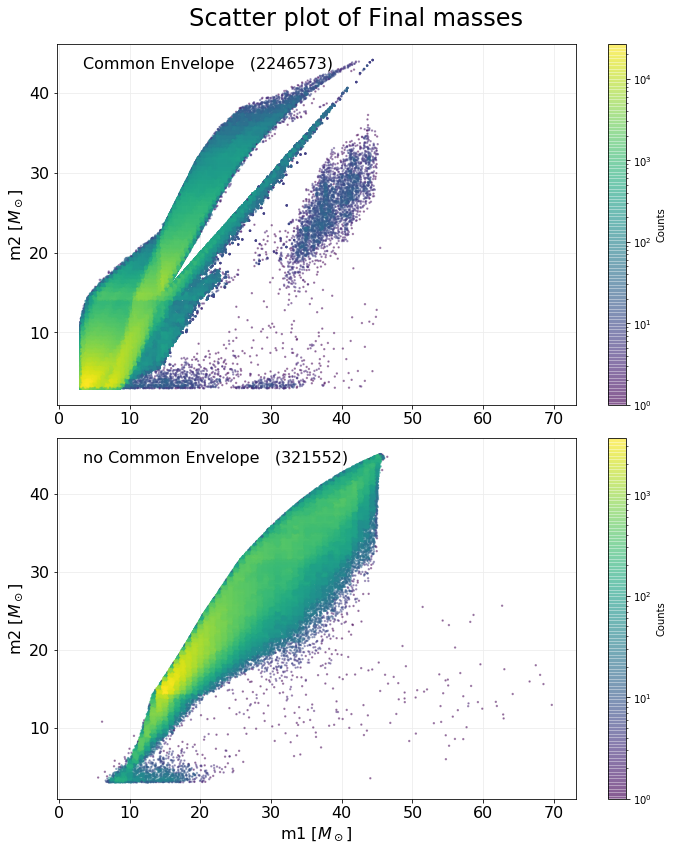

In [10]:
# Plot of the histograms

start_time = time.time()

plot_hist.mass(df_fMT_CE,df_fMT_nCE,fMT,'m1_init','m1 initial')
plot_hist.mass(df_fMT_CE,df_fMT_nCE,fMT,'m2_init','m2 initial')
plot_hist.mass(df_fMT_CE,df_fMT_nCE,fMT,'m1_fin','m1 final')
plot_hist.mass(df_fMT_CE,df_fMT_nCE,fMT,'m2_fin','m2 final')

plot_hist.dtimes(df_fMT_CE,df_fMT_nCE,fMT)

plot_hist.mass_ratio(df_fMT_CE, fMT, 'CE')
plot_hist.mass_ratio(df_fMT_nCE, fMT, 'nCE')

plot_hist.sep(df_fMT_CE,df_fMT_nCE,fMT)

end_time = time.time()
print("Times in seconds: "+str(end_time-start_time))

In [ ]:
start_time = time.time()

plot_hist.scatter_mass(df_fMT_CE,df_fMT_nCE,fMT,'Initial masses')
plot_hist.scatter_mass(df_fMT_CE,df_fMT_nCE,fMT,'Final masses')
#plot_hist.scatter_mass(df_fMT_CE,df_fMT_nCE,fMT,'Ordered final masses') #non è molto interessante 

end_time = time.time()
print("Times in seconds: "+str(end_time-start_time))